In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
import pooch
from matplotlib.lines import Line2D
from scipy import stats

In [2]:
import WetBulb

# Generate temperature range (in degrees C)
N_steps = 500

min_temp = 20
max_temp = 40

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0.01
max_q = 0.025

q = np.linspace(min_q, max_q, N_steps)

# Calculate wet bulb temperature grid
pres = 1000*100 # set general surface pressure to 1000 hPa

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
pres_grid = np.ones_like(temp_grid)*pres

Twb,Teq,epott = WetBulb.WetBulb(temp_grid, pres_grid, q_grid, HumidityMode = 0)
print('Wet bulb has been calculated.')

Wet bulb has been calculated


In [3]:
# Shade saturated region
from scipy.interpolate import griddata

def grid(x, y, z, resX=1000, resY=1000):
    
    #prepare to create grid
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    #grid x, y, z
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method='linear')
    return X, Y, Z

# Make gridded arrays
RH_grid = 0.263*(1000*100)*q_grid*(np.exp((17.67*temp_grid/(temp_grid+273.15-29.65))))**(-1);

e_s = 6.11*np.exp(((2.5*(10**6))/461.52)*((1/273.15) - (1/(temp_grid+273.15)))) #saturation vapor pressure in hPa
e = e_s*RH_grid/100 #vapor pressure in hPa
sat_def = e_s - e #in hPa

temp_array = temp_grid.flatten(order = 'C')
q_array = q_grid.flatten(order = 'C')
RH_array = RH_grid.flatten(order = 'C')
SD_array = sat_def.flatten(order = 'C')

data = pd.DataFrame({'Temperature': temp_array, 'Specific Humidity': q_array, 'Relative Humidity': RH_array,'Saturation Deficit': SD_array})

# Select saturation curve
data_CC_RH = data[(data['Relative Humidity'] <= 100.1) & (data['Relative Humidity'] >= 99.9)]
data_CC_SD = data[(data['Saturation Deficit'] <= 0.01) & (data['Saturation Deficit'] >= -0.01)]

(10, 25)

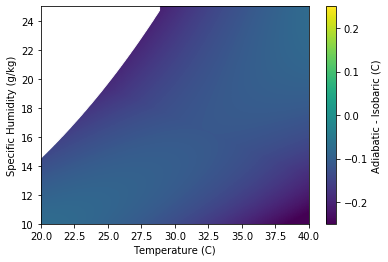

In [5]:
# Calculate isobaric Tw based on Li et al. 2020

def e_sat(T):
    # saturation (mass) mixing ratio
    # Bolton's formula for saturation vapor pressure
    Tc = T - 273.15     # temperature in Celsius
    e_sat = 611.2 * np.exp(17.67 * Tc / (Tc + 243.5))
    return e_sat
    
def r_sat(T, p):
    # saturation (mass) mixing ratio
    e_s = e_sat(T)
    return e_s * 0.622 / (p - e_s)

def q_sat(T, p):
    Tc = T - 273.15     # temperature in Celsius
    e_sat = 611.2 * np.exp(17.67 * Tc / (Tc + 243.5))
    return e_sat * 0.622 / (p - e_sat)

def wbt_isobaric(T, h, p, h_type='s', p_type='sf'):
    # T: [dry bulb] temperature (K)
    # h: humidity (specific, relative, or dewpoint)
    #    types: relative ['r'], specific ['s'], or dewpoint ['d'])
    # p: pressure in Pa
    #    types: surface ['sf'] or sea level ['sl']
    # r: mass mixing ratio of water vapor
    # ps: surface pressure in Pa
    # Z: global constant for surface height
    #
    cp = 1005.7         # specific heat of dry air
    L0 = 2.501e6        # latent heat of vaporization (at 273.15K)
    l = 0.00237e6       # temperature dependence of latent heat
    g = 9.80616
    Ra = 287.
    gamma = -0.0065
    #
    if p_type == 'sf':
        ps = p
    else:
        # convert sea level pressure to surface pressure
        # (when surface pressure is not available)
        ps = p * (1 - gamma * Z / T)**(g / Ra / gamma)
    # Note that due to exponential shape of Clausius-Clayperon relation
    # and associated strong non-linearity,
    # relative humidity is not appropriate for daily-averaged fields,
    # only valid for instantaneous fields
    if h_type == 'r':
        # relative humidity to mixing ratio
        e = e_sat(T) * h
        r0 = e * 0.622 / (ps - e)       
        ind_sat = (h >= 1.0)            # index for saturated points
    elif h_type == 's':
        # specific humidity to mixing ratio
        r0 = h / (1 - h)
        ind_sat = (h >= q_sat(T, ps))   # index for saturated points
    elif h_type == 'd':
        # dewpoint temperature to mixing ratio
        r0 = r_sat(h, ps)
        ind_sat = (h >= T)              # index for saturated points
    else:
        print('Please provide a valid flag for humidity (r-relative, s-specific, d-dewpoint T)')
    # bisection method
    T1 = T - (L0 - l * (T - 273.15)) * (r_sat(T, ps) - r0) / cp
    T2 = T.copy()                # must use copy or T will change
    n = 0
    while np.max(T2 - T1) > 1e-4:
        Tm = (T1 + T2) / 2
        r = r_sat(Tm, ps)        # saturated mixing ratio at Tm
        ind1 = (cp * (T - Tm) >= (L0 - l * (T - 273.15)) * (r - r0))
        ind2 = ~ind1
        T1[ind1] = Tm[ind1]
        T2[ind2] = Tm[ind2]
        n += 1
    # print(n)
    Tw = Tm
    Tw[ind_sat] = T[ind_sat]
    return Tm

# Calculate wet bulb temperature grid
temp_grid, q_grid = np.meshgrid(temp, q) 
pres_grid = np.ones_like(temp_grid)*pres

temp_grid_forcalc = temp_grid + 273.15

ITW = wbt_isobaric(temp_grid_forcalc, q_grid, pres_grid, h_type='s', p_type='sf')

ITW_C = ITW - 273.15

# Plot difference between adiabatic Tw and ITW on grid
mesh = plt.pcolormesh(temp,1000*q, Twb-ITW_C, vmin = -0.25, vmax = 0.25)
cbar = plt.colorbar(mesh, label = 'Adiabatic - Isobaric (C)', pad = 0.05)
plt.xlabel('Temperature (C)')
plt.ylabel('Specific Humidity (g/kg)')

shading = plt.fill_between(data_CC_SD['Temperature'], 1000*data_CC_SD['Specific Humidity'], 1000, color='white', alpha=1)
plt.ylim([10,25])